# Applied Data Science Capstone
# The Battle of Neighborhoods
# Segmenting Madrid


In [1]:
import codecs
import csv
import pandas as pd
from geopy.geocoders import Nominatim
import folium
import os
import math
import time
import requests
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors



## 1. Build neighborhoods list

In [2]:
city_data = pd.DataFrame(columns =["neighborhood", "latitude", "longitude"])

with codecs.open("madrid-district-neighborhoods.csv", "r", "utf-8") as districts_file:
    districts_reader = csv.reader(districts_file, delimiter=":")
    for row in districts_reader:
        #print(': '.join(row))
        district = row[0]
        neighborhoods = [x.strip() for x in row[1].split(',')]
        for neigh in neighborhoods: 
            city_data = city_data.append(
                {
                 "neighborhood" : "{},{}".format(district, neigh)
                }, 
                ignore_index=True
            )

In [3]:
print(city_data.shape)
city_data.head()

(118, 3)


,neighborhood,latitude,longitude
0,"Centro,Palacio",NaN,NaN
1,"Centro,Embajadores",NaN,NaN
2,"Centro,Cortes",NaN,NaN
3,"Centro,Justicia",NaN,NaN
4,"Centro,Universidad",NaN,NaN


## 2. Neighborhoods geolocation

In [4]:
geolocator = Nominatim()

country = "Spain"
city = "Madrid"

geocode_filename = "madrid-district-neighborhoods-geocode.csv" 

# if file exists
if os.path.isfile(geocode_filename):
    with codecs.open(geocode_filename, "r", "utf-8") as geocode_file:
        geocode_reader = csv.reader(geocode_file, delimiter=";")
        for row in geocode_reader:
            neighborhood = row[0]
            latitude = row[1]
            longitude = row[2]
            city_data.loc[city_data['neighborhood'] == neighborhood, 'latitude'] = float(latitude)
            city_data.loc[city_data['neighborhood'] == neighborhood, 'longitude'] = float(longitude)
    

with codecs.open(geocode_filename, "a", "utf-8") as geocode_file:
    for index, row in city_data.iterrows():
        latitude = float(row['latitude'])
        longitude = float(row['longitude'])
        
        if math.isnan(latitude) == True | math.isnan(longitude) == True:
            neighborhood = row['neighborhood']
            address = "{},{},{}".format(neighborhood, city, country)
            retries = 3
            while (retries > 0):
                try:
                    location = geolocator.geocode(address)
                    latitude = location.latitude
                    longitude = location.longitude
                    print("{} : ({},{})".format(address, latitude, longitude))
                    city_data.loc[index, 'latitude'] = float(latitude)
                    city_data.loc[index, 'longitude'] = float(longitude)
                    geocode_file.write("{};{};{}\n".format(neighborhood, latitude, longitude))
                    retries = 0
                except:
                    print("ERROR: ", address)
                    retries = retries - 1
                    time.sleep(1)


C:\ds\anaconda\lib\site-packages\geopy\geocoders\osm.py:143: UserWarning: Using Nominatim with the default "geopy/1.17.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  UserWarning


In [5]:
print(city_data.shape)
city_data.head()

(118, 3)


,neighborhood,latitude,longitude
0,"Centro,Palacio",40.4151,-3.71562
1,"Centro,Embajadores",40.405,-3.70238
2,"Centro,Cortes",40.4143,-3.69853
3,"Centro,Justicia",40.424,-3.69575
4,"Centro,Universidad",37.7898,-3.78164


In [6]:
city = "Madrid"
location = geolocator.geocode(city)
city_latitude = location.latitude
city_longitude = location.longitude
city_map = folium.Map(location=[city_latitude, city_longitude], zoom_start=11)
for lat, lng, neighborhood in zip(city_data['latitude'], city_data['longitude'], city_data['neighborhood']):
    if math.isnan(lat) == False & math.isnan(lng) == False:
        label_txt = "{}, {}".format(neighborhood, city)
        label = folium.Popup(label_txt, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color='blue',
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.7).add_to(city_map) 

city_map

## 3. Venues compilation

In [7]:
# Foursquare ID and Secret are taken from environment variables for security.
CLIENT_ID = os.environ.get("FOURSQUARE_CLIENT_ID")
CLIENT_SECRET = os.environ.get("FOURSQUARE_CLIENT_SECRET")
VERSION = '20180605' # Foursquare API version

#print('CLIENT_ID: ' + CLIENT_ID)
#print('CLIENT_SECRET:' + CLIENT_SECRET)

In [8]:
def getNearbyVenues(names, latitudes, longitudes, radius=800, LIMIT = 100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
        
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        try:
            # make the GET request
            results = requests.get(url).json()["response"]['groups'][0]['items']
        
            # return only relevant information for each nearby venue
            venues_list.append([(
                name, 
                lat, 
                lng, 
                v['venue']['name'], 
                v['venue']['location']['lat'], 
                v['venue']['location']['lng'],  
                v['venue']['categories'][0]['name']) for v in results])

        except:
            print("ERROR: ", url)

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['neighborhood', 
                  'neighborhood_latitude', 
                  'neighborhood_longitude', 
                  'venue', 
                  'venue_latitude', 
                  'venue_longitude', 
                  'venue_category']
    
    return(nearby_venues)


In [9]:
venues_filename = "madrid-district-neighborhoods-venues.csv"

if os.path.isfile(venues_filename):
    with codecs.open(venues_filename, "r", "utf-8") as venues_file:
        venues_reader = csv.reader(venues_file, delimiter=";")        
        venues_list = []        
        for row in venues_reader:
            venues_list.append([( row[0], row[1], row[2], row[3], row[4], row[5], row[6])])
            
        city_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
        city_venues.columns = ['neighborhood', 'neighborhood_latitude', 'neighborhood_longitude', 
                  'venue', 'venue_latitude', 'venue_longitude', 'venue_category']

else:
    city_venues = getNearbyVenues(names=city_data['neighborhood'],
                              latitudes=city_data['latitude'],
                              longitudes=city_data['longitude']
                              )

    with codecs.open(venues_filename, "w", "utf-8") as venues_file:
        for index, row in city_venues.iterrows():
            neighborhood = row['neighborhood']
            neighborhood_latitude = row['neighborhood_latitude']
            neighborhood_longitude = row['neighborhood_longitude']
            venue = row['venue']
            venue_latitude = row['venue_latitude']
            venue_longitude = row['venue_longitude']
            venue_category = row['venue_category']
            venues_file.write("{};{};{};{};{};{};{}\n"
                              .format(neighborhood, neighborhood_latitude, neighborhood_longitude,
                                      venue, venue_latitude, venue_longitude, venue_category))


In [10]:
print("shape {}".format(city_venues.shape))
city_venues.head()

shape (3346, 7)


,neighborhood,neighborhood_latitude,neighborhood_longitude,venue,venue_latitude,venue_longitude,venue_category
0,"Centro,Palacio",40.41512925,-3.71561799839909,Santa Iglesia Catedral de Santa María la Real ...,40.41576693264202,-3.7145161628723145,Church
1,"Centro,Palacio",40.41512925,-3.71561799839909,Park de La Almudena,40.41631960737639,-3.713776929870609,Park
2,"Centro,Palacio",40.41512925,-3.71561799839909,Cervecería La Mayor,40.41521786102789,-3.7121938520878386,Bar
3,"Centro,Palacio",40.41512925,-3.71561799839909,Taberna Rayuela,40.41317891156541,-3.7134962971934686,Tapas Restaurant
4,"Centro,Palacio",40.41512925,-3.71561799839909,Corral de la Morería,40.412619019854375,-3.7142493289306913,Art Gallery


In [11]:
print('{} uniques categories'.format(len(city_venues['venue_category'].unique())))


127 uniques categories


## 4. Neighborhoods segmentation 

In [12]:
dummy_df = pd.get_dummies(city_venues[['venue_category']], prefix="", prefix_sep="")
# add neighborhood column back to dataframe and move column to the first column
dummy_df['neighborhood'] = city_venues['neighborhood'] 
col_index = dummy_df.columns.tolist().index('neighborhood')
col_order = [dummy_df.columns[col_index]] \
                + list(dummy_df.columns[0:col_index]) \
                + list(dummy_df.columns[col_index+1:])
dummy_df = dummy_df[col_order]
print(dummy_df.shape)
dummy_df.head()

(3346, 128)


,neighborhood,American Restaurant,Argentinian Restaurant,Art Gallery,Athletics & Sports,BBQ Joint,Bar,Basketball Stadium,Beach,Beer Store,...,Thrift / Vintage Store,Toy / Game Store,Track,Trade School,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Winery,Yoga
0,"Centro,Palacio",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"Centro,Palacio",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Centro,Palacio",0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Centro,Palacio",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"Centro,Palacio",0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
city_grouped = dummy_df.groupby('neighborhood').mean().reset_index()
print(city_grouped.shape)
city_grouped.head()

(118, 128)


,neighborhood,American Restaurant,Argentinian Restaurant,Art Gallery,Athletics & Sports,BBQ Joint,Bar,Basketball Stadium,Beach,Beer Store,...,Thrift / Vintage Store,Toy / Game Store,Track,Trade School,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Winery,Yoga
0,"Arganzuela,Acacias",0.000000,0.0,0.068182,0.0,0.0,0.181818,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.022727,0.0
1,"Arganzuela,Atocha",0.015385,0.0,0.000000,0.0,0.0,0.061538,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.030769,0.0,0.0,0.0,0.000000,0.0
2,"Arganzuela,Delicias",0.000000,0.0,0.027778,0.0,0.0,0.111111,0.0,0.0,0.0,...,0.0,0.0,0.0,0.027778,0.027778,0.0,0.0,0.0,0.000000,0.0
3,"Arganzuela,Imperial",0.000000,0.0,0.000000,0.0,0.0,0.035714,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0
4,"Arganzuela,La Chopera",0.000000,0.0,0.035714,0.0,0.0,0.107143,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0


In [14]:
Y = city_grouped.drop('neighborhood', 1)
print(Y.shape)
Y.head()

(118, 127)


,American Restaurant,Argentinian Restaurant,Art Gallery,Athletics & Sports,BBQ Joint,Bar,Basketball Stadium,Beach,Beer Store,Bistro,...,Thrift / Vintage Store,Toy / Game Store,Track,Trade School,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Winery,Yoga
0,0.000000,0.0,0.068182,0.0,0.0,0.181818,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.022727,0.0
1,0.015385,0.0,0.000000,0.0,0.0,0.061538,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.030769,0.0,0.0,0.0,0.000000,0.0
2,0.000000,0.0,0.027778,0.0,0.0,0.111111,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.027778,0.027778,0.0,0.0,0.0,0.000000,0.0
3,0.000000,0.0,0.000000,0.0,0.0,0.035714,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0
4,0.000000,0.0,0.035714,0.0,0.0,0.107143,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0


- **Before execute K-means we plot the Elbow Curve for determining the best K value**

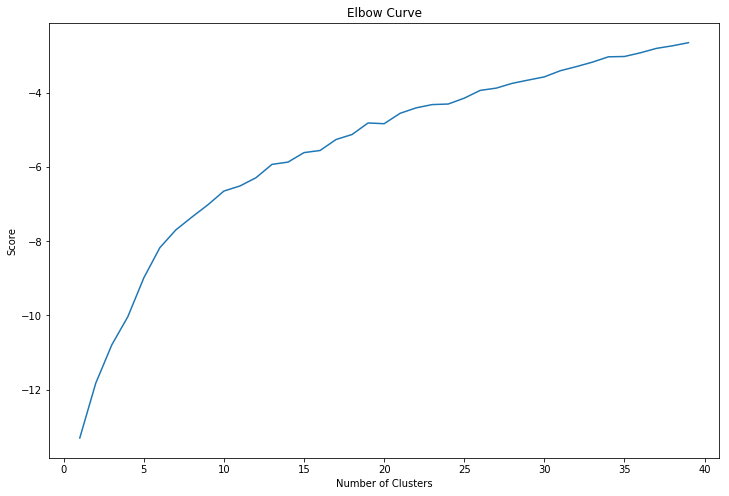

In [15]:
Nc = range(1, 40)
kmeans = [KMeans(n_clusters=i) for i in Nc]
kmeans
score = [kmeans[i].fit(Y).score(Y) for i in range(len(kmeans))]

plt.figure(1, figsize=(12, 8))
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [16]:
# set number of clusters
kclusters = 10
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Y)
# check cluster labels generated for each row in the dataframe
print(len(kmeans.labels_))
kmeans.labels_

118


array([0, 9, 0, 9, 6, 0, 0, 4, 0, 5, 0, 8, 1, 0, 6, 0, 6, 8, 9, 0, 0, 6,
       6, 1, 9, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 1, 8, 0, 5,
       5, 6, 1, 0, 9, 8, 6, 0, 9, 9, 0, 0, 6, 0, 8, 0, 1, 0, 0, 6, 0, 5,
       5, 9, 8, 6, 8, 1, 6, 8, 6, 9, 8, 5, 0, 0, 5, 9, 9, 0, 9, 1, 9, 0,
       0, 9, 8, 8, 9, 0, 3, 8, 5, 6, 0, 0, 0, 0, 0, 0, 5, 0, 1, 7, 6, 8,
       0, 0, 0, 2, 8, 1, 1, 5])

In [17]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]


In [18]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
colnames = ['neighborhood']
for ind in np.arange(num_top_venues):
    try:
        colnames.append('{}{}'.format(ind+1, indicators[ind]))
    except:
        colnames.append('{}th'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=colnames)
neighborhoods_venues_sorted['neighborhood'] = city_grouped['neighborhood']

for ind in np.arange(city_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(city_grouped.iloc[ind, :], num_top_venues)

print(neighborhoods_venues_sorted.shape)
neighborhoods_venues_sorted.head()

(118, 11)


,neighborhood,1st,2nd,3rd,4th,5th,6th,7th,8th,9th,10th
0,"Arganzuela,Acacias",Bar,Theater,Spanish Restaurant,Tapas Restaurant,Coffee Shop,Art Gallery,Park,Market,Pizza,Sporting Goods Shop
1,"Arganzuela,Atocha",Spanish Restaurant,Gym,Fast Food Restaurant,Hotel,Park,Bar,Tapas Restaurant,Museum,Coffee Shop,Grocery Store
2,"Arganzuela,Delicias",Tapas Restaurant,Spanish Restaurant,Bar,Market,Coffee Shop,Chinese Restaurant,Museum,Dessert Shop,Park,Gym
3,"Arganzuela,Imperial",Spanish Restaurant,Coffee Shop,Park,Hotel,Gym,Japanese Restaurant,Pizza,Grocery Store,Spa,Chinese Restaurant
4,"Arganzuela,La Chopera",Park,Spanish Restaurant,Bar,Gym,Food & Drink Shop,Italian Restaurant,Tapas Restaurant,Coffee Shop,Pool,Theater


In [19]:
city_merged = city_data
print(city_merged.shape)

# add clustering labels
city_merged['cluster-label'] = kmeans.labels_
# merge city_grouped with city_data to add latitude/longitude for each neighborhood
city_merged = city_merged.join(neighborhoods_venues_sorted.set_index('neighborhood'), on='neighborhood')

print(city_merged.shape)
city_merged.head()

(118, 3)
(118, 14)


,neighborhood,latitude,longitude,cluster-label,1st,2nd,3rd,4th,5th,6th,7th,8th,9th,10th
0,"Centro,Palacio",40.4151,-3.71562,0,Spanish Restaurant,Park,Bar,Tapas Restaurant,Gym,Art Gallery,Vegetarian / Vegan Restaurant,Mexican Restaurant,Pub,Museum
1,"Centro,Embajadores",40.405,-3.70238,9,Spanish Restaurant,Bar,Coffee Shop,Theater,Gym,Tapas Restaurant,Art Gallery,Park,Pizza,Market
2,"Centro,Cortes",40.4143,-3.69853,0,Spanish Restaurant,Hotel,Bar,Theater,Art Gallery,Museum,Coffee Shop,Park,Pub,Mediterranean Restaurant
3,"Centro,Justicia",40.424,-3.69575,9,Bar,Spanish Restaurant,Pub,Chinese Restaurant,Italian Restaurant,Hotel,Clothing Store,Flower Shop,Museum,Vegetarian / Vegan Restaurant
4,"Centro,Universidad",37.7898,-3.78164,6,Tapas Restaurant,Mediterranean Restaurant,Fast Food Restaurant,Japanese Restaurant,Grocery Store,Yoga,French Restaurant,Gym,Greek Restaurant,Food & Drink Shop


## 5. Segments analysis

In [20]:
# create map
city = "Madrid"
location = geolocator.geocode(city)
city_latitude = location.latitude
city_longitude = location.longitude
map_clusters = folium.Map(location=[city_latitude, city_longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(city_merged['latitude'], city_merged['longitude'], \
                                  city_merged['neighborhood'], city_merged['cluster-label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [21]:
def print_cluster_info(cluster_number):
    #print("Cluster {} - Size {}".format(cluster_number+1, len(city_merged[city_merged['cluster-label'] == cluster_number])))
    cluster_data = city_merged.loc[city_merged['cluster-label'] == cluster_number,city_merged.columns[[0]+list(range(4,city_merged.shape[1]))]]
    #cluster_venues_list = []
    #for idx, row in cluster_data.iterrows():
    #    for i in range(1,row.shape[0]):
    #        cluster_venues_list.append(row[i])
    #cluster_venues = pd.DataFrame(cluster_venues_list, columns=['venue'])    
    #cluster_venues = cluster_venues.groupby('venue').venue.agg('count').to_frame('count').reset_index()
    #cluster_venues.sort_values(by=['count','venue'], ascending=False, inplace=True)
    #print(cluster_venues.head(10))
    return cluster_data


### Cluster 1
  

In [22]:
print_cluster_info(0)

,neighborhood,1st,2nd,3rd,4th,5th,6th,7th,8th,9th,10th
0,"Centro,Palacio",Spanish Restaurant,Park,Bar,Tapas Restaurant,Gym,Art Gallery,Vegetarian / Vegan Restaurant,Mexican Restaurant,Pub,Museum
2,"Centro,Cortes",Spanish Restaurant,Hotel,Bar,Theater,Art Gallery,Museum,Coffee Shop,Park,Pub,Mediterranean Restaurant
5,"Centro,Sol",Bar,Pizza,Park,Pub,Chinese Restaurant,Smoke Shop,Sushi Restaurant,Skate Park,Tapas Restaurant,Coffee Shop
6,"Arganzuela,Imperial",Spanish Restaurant,Coffee Shop,Park,Hotel,Gym,Japanese Restaurant,Pizza,Grocery Store,Spa,Chinese Restaurant
8,"Arganzuela,La Chopera",Park,Spanish Restaurant,Bar,Gym,Food & Drink Shop,Italian Restaurant,Tapas Restaurant,Coffee Shop,Pool,Theater
10,"Arganzuela,Delicias",Tapas Restaurant,Spanish Restaurant,Bar,Market,Coffee Shop,Chinese Restaurant,Museum,Dessert Shop,Park,Gym
13,"Retiro,Pacífico",Bar,Spanish Restaurant,Grocery Store,Museum,Chinese Restaurant,Coffee Shop,Italian Restaurant,Park,Pizza,Art Gallery
15,"Retiro,Estrella",Bar,Spanish Restaurant,Coffee Shop,Chinese Restaurant,Metro Station,Italian Restaurant,Rental Car Location,Dessert Shop,Grocery Store,Gym
19,"Salamanca,Recoletos",Spanish Restaurant,Clothing Store,Coffee Shop,Art Gallery,Hotel,Bar,Italian Restaurant,Japanese Restaurant,Jewelry Store,Tapas Restaurant
20,"Salamanca,Goya",Spanish Restaurant,Chinese Restaurant,Tapas Restaurant,Coffee Shop,Clothing Store,Theater,Art Gallery,Japanese Restaurant,Museum,Ice Cream Shop


### Cluster 2
  

In [23]:
print_cluster_info(1)

,neighborhood,1st,2nd,3rd,4th,5th,6th,7th,8th,9th,10th
12,"Arganzuela,Atocha",Spanish Restaurant,Gym,Fast Food Restaurant,Hotel,Park,Bar,Tapas Restaurant,Museum,Coffee Shop,Grocery Store
23,"Salamanca,Lista",Spanish Restaurant,Chinese Restaurant,Bar,Coffee Shop,Tapas Restaurant,Clothing Store,Food & Drink Shop,Theater,Mediterranean Restaurant,Museum
40,"Fuencarral-El Pardo,El Pardo",Spanish Restaurant,Park,Tapas Restaurant,Bar,Theater,French Restaurant,Hobby Shop,Gym,Grocery Store,Greek Restaurant
46,"Fuencarral-El Pardo,El Goloso",Spanish Restaurant,Train Station,Chinese Restaurant,Yoga,Football Stadium,Gym,Grocery Store,Greek Restaurant,French Restaurant,Food & Drink Shop
60,"Carabanchel,Comillas",Spanish Restaurant,Tapas Restaurant,Market,Bar,Park,Grocery Store,Coffee Shop,Breakfast Spot,Shopping Mall,Bookstore
71,"Usera,Moscardó",Pub,Spanish Restaurant,Fast Food Restaurant,Shopping Mall,Coffee Shop,Pool,Art Gallery,BBQ Joint,Bar,Grocery Store
85,"Ciudad Lineal,Ventas",Spanish Restaurant,Grocery Store,Soccer Field,Market,Bar,Metro Station,Chinese Restaurant,Theater,Park,Pizza
106,"San Blas,Simancas",Park,Bar,Spanish Restaurant,BBQ Joint,French Restaurant,Hobby Shop,Gym,Grocery Store,Greek Restaurant,Food & Drink Shop
115,"Barajas,Aeropuerto",Fast Food Restaurant,Yoga,Hotel,Event Space,Fabric Shop,Fish & Chips Shop,Flower Shop,Food & Drink Shop,Football Stadium,French Restaurant
116,"Barajas,Timón",Spanish Restaurant,Tapas Restaurant,Hotel,Bar,Coffee Shop,Argentinian Restaurant,Art Gallery,Fast Food Restaurant,Pub,Market


### Cluster 3
  

In [24]:
print_cluster_info(2)

,neighborhood,1st,2nd,3rd,4th,5th,6th,7th,8th,9th,10th
113,"San Blas,Salvador",Spanish Restaurant,Pizza,Theater,Fast Food Restaurant,Bar,Market,Grocery Store,Greek Restaurant,French Restaurant,Football Stadium


### Cluster 4
  

In [25]:
print_cluster_info(3)

,neighborhood,1st,2nd,3rd,4th,5th,6th,7th,8th,9th,10th
94,"Hortaleza,Valdefuentes",Spanish Restaurant,Coffee Shop,Park,Chinese Restaurant,Theater,Hot Dog Joint,Gym,Grocery Store,Greek Restaurant,Yoga


### Cluster 5
  

In [26]:
print_cluster_info(4)

,neighborhood,1st,2nd,3rd,4th,5th,6th,7th,8th,9th,10th
7,"Arganzuela,Acacias",Bar,Theater,Spanish Restaurant,Tapas Restaurant,Coffee Shop,Art Gallery,Park,Market,Pizza,Sporting Goods Shop


### Cluster 6

In [27]:
print_cluster_info(5)

,neighborhood,1st,2nd,3rd,4th,5th,6th,7th,8th,9th,10th
9,"Arganzuela,Legazpi",Bar,Spanish Restaurant,Park,Art Gallery,Market,Museum,Coffee Shop,Grocery Store,Argentinian Restaurant,BBQ Joint
33,"Tetuán,Berruguete",Bar,Theater,Market,Spanish Restaurant,Breakfast Spot,Fast Food Restaurant,Pizza,Grocery Store,Kebab Restaurant,Tapas Restaurant
43,"Fuencarral-El Pardo,Barrio del Pilar",Clothing Store,Italian Restaurant,Bar,Fast Food Restaurant,Museum,American Restaurant,Spanish Restaurant,Video Game Store,Food & Drink Shop,Shopping Mall
44,"Fuencarral-El Pardo,Valverde",Scenic Lookout,Spanish Restaurant,Dessert Shop,Moving Target,Coffee Shop,Yoga,Football Stadium,Grocery Store,Greek Restaurant,French Restaurant
65,"Carabanchel,Buenavista",Spanish Restaurant,Tapas Restaurant,Grocery Store,Hotel,Market,Coffee Shop,Food & Drink Shop,Metro Station,Fish & Chips Shop,Flower Shop
66,"Carabanchel,Abrantes",Spanish Restaurant,Fast Food Restaurant,Athletics & Sports,Bar,Pizza,Grocery Store,Park,Soccer Field,Theater,Yoga
77,"Puente de Vallecas,Portazgo",Pizza,Fast Food Restaurant,American Restaurant,Soccer Field,Grocery Store,Clothing Store,Theater,Greek Restaurant,French Restaurant,Food & Drink Shop
80,"Moratalaz,Horcajo",Soccer Field,Park,Fast Food Restaurant,Spanish Restaurant,Italian Restaurant,Pizza,Yoga,Football Stadium,Greek Restaurant,French Restaurant
96,"Hortaleza,Pinar del Rey",Theater,Spanish Restaurant,Chinese Restaurant,Pub,Bar,Coffee Shop,Grocery Store,Soccer Field,Metro Station,Food & Drink Shop
104,"Villa de Vallecas,Santa Eugenia",Theater,Spanish Restaurant,Soccer Field,Train Station,Market,Bar,Neighborhood,Football Stadium,Gym,Grocery Store


### Cluster 7

In [28]:
print_cluster_info(6)

,neighborhood,1st,2nd,3rd,4th,5th,6th,7th,8th,9th,10th
4,"Centro,Universidad",Tapas Restaurant,Mediterranean Restaurant,Fast Food Restaurant,Japanese Restaurant,Grocery Store,Yoga,French Restaurant,Gym,Greek Restaurant,Food & Drink Shop
14,"Retiro,Adelfas",Bar,Spanish Restaurant,Fast Food Restaurant,Grocery Store,Coffee Shop,Hotel,Tapas Restaurant,Chinese Restaurant,Soccer Field,Bus Station
16,"Retiro,Ibiza",Spanish Restaurant,Tapas Restaurant,Italian Restaurant,Bar,Chinese Restaurant,Pub,Mediterranean Restaurant,Bus Station,Food & Drink Shop,Dessert Shop
21,"Salamanca,Fuente del Berro",Grocery Store,Spanish Restaurant,Park,Theater,Mediterranean Restaurant,Soccer Field,Tapas Restaurant,Coffee Shop,Dance Studio,Dive Shop
22,"Salamanca,Guindalera",Spanish Restaurant,Park,Bar,Tapas Restaurant,Hotel,Electronics Store,Grocery Store,Breakfast Spot,Clothing Store,Coffee Shop
45,"Fuencarral-El Pardo,Mirasierra",Coffee Shop,Metro Station,Sports Club,Grocery Store,Shopping Mall,Yoga,Greek Restaurant,French Restaurant,Football Stadium,Flower Shop
50,"Moncloa-Aravaca,Valdezarza",Spanish Restaurant,Chinese Restaurant,Metro Station,Pharmacy,Market,Soccer Field,Football Stadium,Grocery Store,Greek Restaurant,French Restaurant
56,"Latina,Aluche",Spanish Restaurant,Bar,Tapas Restaurant,Pharmacy,Chinese Restaurant,Clothing Store,Shopping Mall,Theater,Park,Latin American Restaurant
63,"Carabanchel,Vista Alegre",Fast Food Restaurant,Grocery Store,Bar,Breakfast Spot,Metro Station,Coffee Shop,Park,Stadium,Tapas Restaurant,Theater
69,"Usera,San Fermín",Market,Park,Breakfast Spot,Fast Food Restaurant,Art Gallery,Athletics & Sports,Metro Station,Pizza,Grocery Store,Spanish Restaurant


### Cluster 8

In [29]:
print_cluster_info(7)

,neighborhood,1st,2nd,3rd,4th,5th,6th,7th,8th,9th,10th
107,"San Blas,Hellín",Metro Station,Spanish Restaurant,Bar,Theater,Yoga,Football Stadium,Gym,Grocery Store,Greek Restaurant,French Restaurant


### Cluster 9

In [30]:
print_cluster_info(8)

,neighborhood,1st,2nd,3rd,4th,5th,6th,7th,8th,9th,10th
11,"Arganzuela,Palos de Moguer",Spanish Restaurant,Gym,Bar,Theater,Chinese Restaurant,Fast Food Restaurant,Park,Breakfast Spot,Coffee Shop,Museum
17,"Retiro,Jerónimos",Park,Coffee Shop,Museum,Spanish Restaurant,Fast Food Restaurant,Monument / Landmark,Theater,Hotel,Tea Room,Mediterranean Restaurant
41,"Fuencarral-El Pardo,Fuentelarreina",Park,Bar,Soccer Field,Spanish Restaurant,Grocery Store,Breakfast Spot,Clothing Store,Shopping Mall,Pizza,Food & Drink Shop
49,"Moncloa-Aravaca,Ciudad Universitaria",Park,Bus Station,Spanish Restaurant,Museum,Greek Restaurant,Hot Dog Joint,Hobby Shop,Gym,Grocery Store,Yoga
58,"Latina,Campamento",Bar,Spanish Restaurant,Clothing Store,Grocery Store,Fast Food Restaurant,Pizza,Italian Restaurant,Tapas Restaurant,Coffee Shop,Theater
68,"Usera,Orcasur",Train Station,Bar,Yoga,Football Stadium,Hobby Shop,Gym,Grocery Store,Greek Restaurant,French Restaurant,Flower Shop
70,"Usera,Almendrales",Spanish Restaurant,Pub,Chinese Restaurant,Fast Food Restaurant,Train Station,BBQ Joint,Bar,Grocery Store,Theater,French Restaurant
73,"Usera,Pradolongo",Park,Spanish Restaurant,Athletics & Sports,Bar,French Restaurant,Hobby Shop,Gym,Grocery Store,Greek Restaurant,Food & Drink Shop
76,"Puente de Vallecas,Palomeras Bajas",Food & Drink Shop,Park,Market,Toy / Game Store,Coffee Shop,Football Stadium,Gym,Grocery Store,Greek Restaurant,French Restaurant
90,"Ciudad Lineal,San Juan Bautista",Spanish Restaurant,Bar,Market,Shopping Mall,Hotel,Museum,Theater,Pharmacy,Clothing Store,Chinese Restaurant


### Cluster 10

In [31]:
print_cluster_info(9)

,neighborhood,1st,2nd,3rd,4th,5th,6th,7th,8th,9th,10th
1,"Centro,Embajadores",Spanish Restaurant,Bar,Coffee Shop,Theater,Gym,Tapas Restaurant,Art Gallery,Park,Pizza,Market
3,"Centro,Justicia",Bar,Spanish Restaurant,Pub,Chinese Restaurant,Italian Restaurant,Hotel,Clothing Store,Flower Shop,Museum,Vegetarian / Vegan Restaurant
18,"Retiro,Niño Jesús",Spanish Restaurant,Park,Coffee Shop,Bar,Market,Jazz Club,Chinese Restaurant,Grocery Store,Sporting Goods Shop,Italian Restaurant
24,"Salamanca,Castellana",Spanish Restaurant,Coffee Shop,Clothing Store,Bar,Bistro,Mediterranean Restaurant,Tapas Restaurant,Museum,Pub,Art Gallery
48,"Moncloa-Aravaca,Argüelles",Spanish Restaurant,Tapas Restaurant,Fast Food Restaurant,Bar,Coffee Shop,Pub,Pizza,Chinese Restaurant,Salad Place,Museum
52,"Moncloa-Aravaca,El Plantío",Spanish Restaurant,Shopping Mall,Italian Restaurant,American Restaurant,Sporting Goods Shop,Clothing Store,Coffee Shop,Bookstore,Japanese Restaurant,Theater
53,"Moncloa-Aravaca,Aravaca",Grocery Store,Spanish Restaurant,Italian Restaurant,Spa,Bodega,Pizza,Yoga,French Restaurant,Greek Restaurant,Football Stadium
67,"Usera,Orcasitas",Kids Store,Sporting Goods Shop,Grocery Store,Coffee Shop,Market,Yoga,Greek Restaurant,French Restaurant,Football Stadium,Food & Drink Shop
75,"Puente de Vallecas,San Diego",Spanish Restaurant,Bar,Italian Restaurant,Tapas Restaurant,Theater,Pub,Market,Fast Food Restaurant,Fish & Chips Shop,Gym
81,"Moratalaz,Marroquina",Bar,Park,Tapas Restaurant,Theater,French Restaurant,Hot Dog Joint,Hobby Shop,Gym,Grocery Store,Greek Restaurant
